In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
pip install seaborn

In [2]:
# Path ke dataset
train_dir = r'D:\Ara\bougainville\training'
val_dir = r'D:\Ara\bougainville\validation'

In [11]:
# Augmentasi data dengan validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Tambahkan validation split
)

# Gunakan subset 'training' untuk train_generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Gunakan subset 'validation' untuk val_generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Mapping label
label_map = train_generator.class_indices
print("Label mapping:", label_map)

Found 320 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Label mapping: {'afterglow': 0, 'coconutice': 1, 'glabra': 2, 'goldrush': 3, 'spectabilis': 4}


In [5]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),  # Penambahan dropout ringan di awal

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(train_generator.num_classes, activation='softmax')
])

d:\Ara\Web\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Load base model
base_model = MobileNetV2(input_shape=(150,150,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze layer awal

# Tambahkan classifier di atasnya
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)


In [9]:
# Menyimpan model
model.save('model_bougainville.keras')

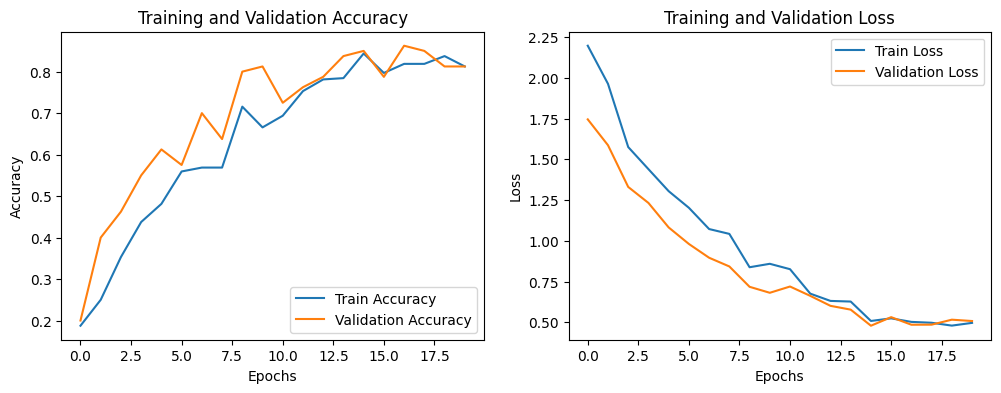

In [7]:
# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [28]:
# Evaluasi model dan classification report
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys(), zero_division=1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Classification Report:
              precision    recall  f1-score   support

   afterglow       0.11      0.12      0.12        16
  coconutice       0.21      0.19      0.20        16
      glabra       0.17      0.19      0.18        16
    goldrush       0.33      0.31      0.32        16
 spectabilis       0.07      0.06      0.06        16

    accuracy                           0.17        80
   macro avg       0.18      0.17      0.18        80
weighted avg       0.18      0.17      0.18        80



In [20]:
# Menguji model dengan input gambar
def load_and_preprocess_image(image_path):
    img = plt.imread(image_path)
    img = np.resize(img, (150, 150, 3))  # Resize gambar ke ukuran yang sesuai
    img = img.astype('float32') / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambahkan dimensi batch
    return img
def predict_image(model, image_path):
    img = load_and_preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)
    if predicted_class == 0:
      predict_label = 'Afterglow'
    elif predicted_class == 1:
        predict_label = 'Coconutice'
    elif predicted_class == 2:
        predict_label = 'Glabra'
    elif predicted_class == 3:
        predict_label = 'Goldrush'
    elif predicted_class == 4:
        predict_label = 'Spectabilis'
    else:
        predict_label = 'Tidak Teridentifikasi'
    return predict_label
# Contoh penggunaan
image_path = r'D:\Ara\bougainville\validation\glabra\IMG_20241225_154014 (Copy).jpg'  # Ganti dengan path gambar yang ingin diuji
predicted_class = predict_image(model, image_path)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: Spectabilis


In [24]:
# Prediksi menggunakan model
val_generator.reset()
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)


d:\Ara\Web\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step


In [25]:
# Label sebenarnya
y_true = val_generator.classes

# Nama kelas
class_names = list(val_generator.class_indices.keys())


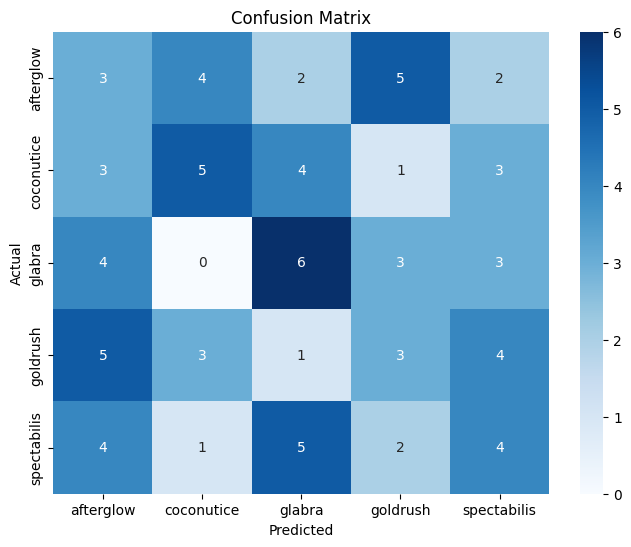

In [26]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
